In [100]:
# Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [127]:
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin

yfin.pdr_override()

df = pdr.get_data_yahoo('TSLA', start='2009-01-01', end='2023-12-23')

df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2023-12-18,253.779999,258.739990,251.360001,252.080002,252.080002,116416500
2023-12-19,253.479996,258.339996,253.009995,257.220001,257.220001,106737400
2023-12-20,256.410004,259.839996,247.000000,247.139999,247.139999,125097000


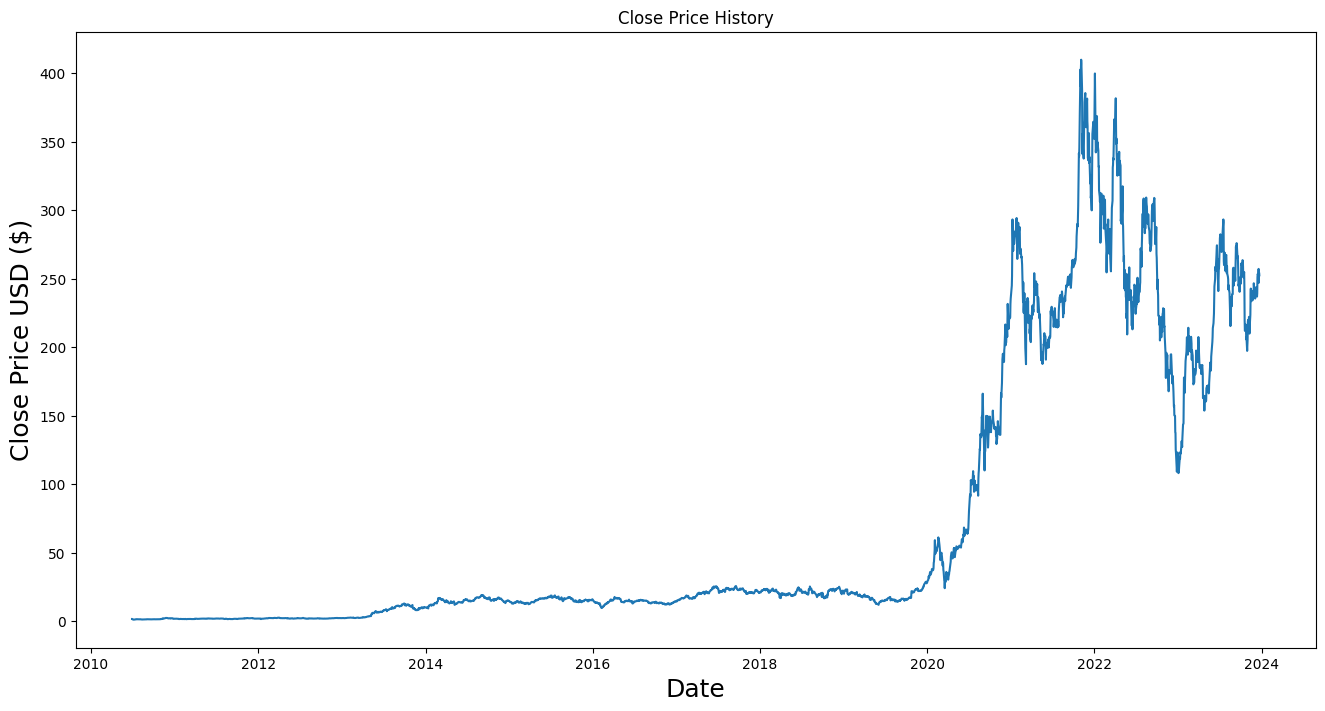

In [128]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [129]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .75 ))

training_data_len

2547

In [130]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.60180151],
       [0.61980028],
       [0.61500711]])

In [131]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([1.31893362e-03, 1.30915180e-03, 1.00428027e-03, 5.54310805e-04,
       5.05407544e-05, 0.00000000e+00, 2.70634579e-04, 2.60852469e-04,
       2.03792057e-04, 3.81495574e-04, 6.58652434e-04, 6.66803171e-04,
       7.89077648e-04, 9.96129534e-04, 7.33645693e-04, 7.20604046e-04,
       8.47769140e-04, 8.95047734e-04, 8.39618402e-04, 7.74404629e-04,
       8.02119295e-04, 7.41799054e-04, 6.74953909e-04, 8.34727493e-04,
       1.00264919e-03, 8.90156824e-04, 7.58100530e-04, 6.17893497e-04,
       6.19524578e-04, 5.26596139e-04, 3.42368009e-04, 2.93458335e-04,
       4.10841611e-04, 4.85837203e-04, 5.46160067e-04, 4.84206122e-04,
       4.87468283e-04, 5.38006705e-04, 7.05931027e-04, 5.54310805e-04,
       6.68434252e-04, 6.43979415e-04, 6.35826345e-04, 6.63543343e-04,
       5.99960650e-04, 7.58100530e-04, 8.57551250e-04, 8.55919878e-04,
       7.72773549e-04, 8.31465041e-04, 8.00490546e-04, 7.12453017e-04,
       8.02119295e-04, 8.67333068e-04, 1.00754010e-03, 8.37987322e-04,
     

In [132]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [133]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2487, 60, 1)

In [134]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dense_10 (Dense)            (None, 25)                1275      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [135]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [136]:
model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
2487/2487 [==============================] - 94s 36ms/step - loss: 1.3280e-04
Epoch 2/2
2487/2487 [==============================] - 91s 36ms/step - loss: 4.2599e-05


In [137]:
# Test data preparation
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [138]:
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [139]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

27/27 [==============================] - 2s 26ms/step


In [140]:
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 210.0618983740356
R-squared: 0.9432295639852759
Mean Absolute Error: 11.178440844352732
Root Mean Squared Error: 14.49351228564131


<ipython-input-141-143c1efe74ec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


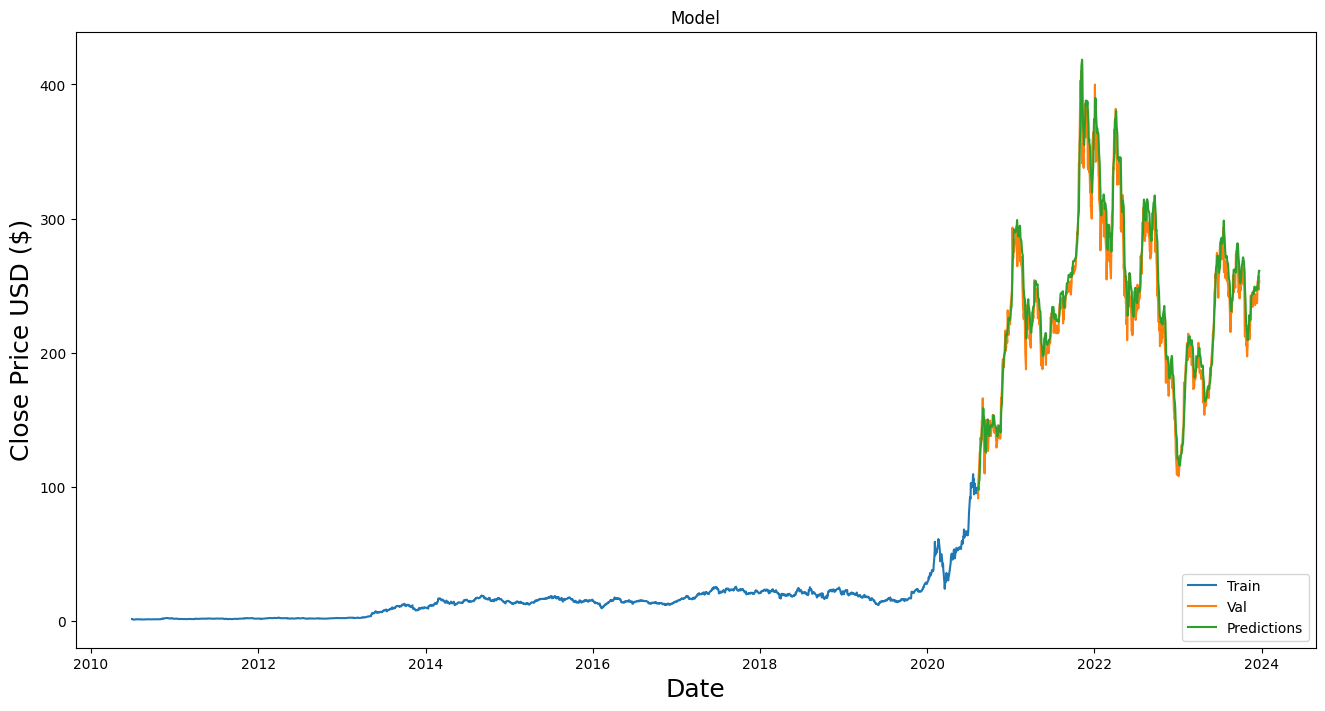

In [141]:
train = data[:training_data_len]
valid = data[training_data_len:]
future = data[training_data_len:]
valid['Predictions'] = predictions


plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [142]:
# Calculate the difference between actual and predicted values
valid['Difference'] = valid['Close'] - valid['Predictions']

<ipython-input-142-bcf79acace00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference'] = valid['Close'] - valid['Predictions']


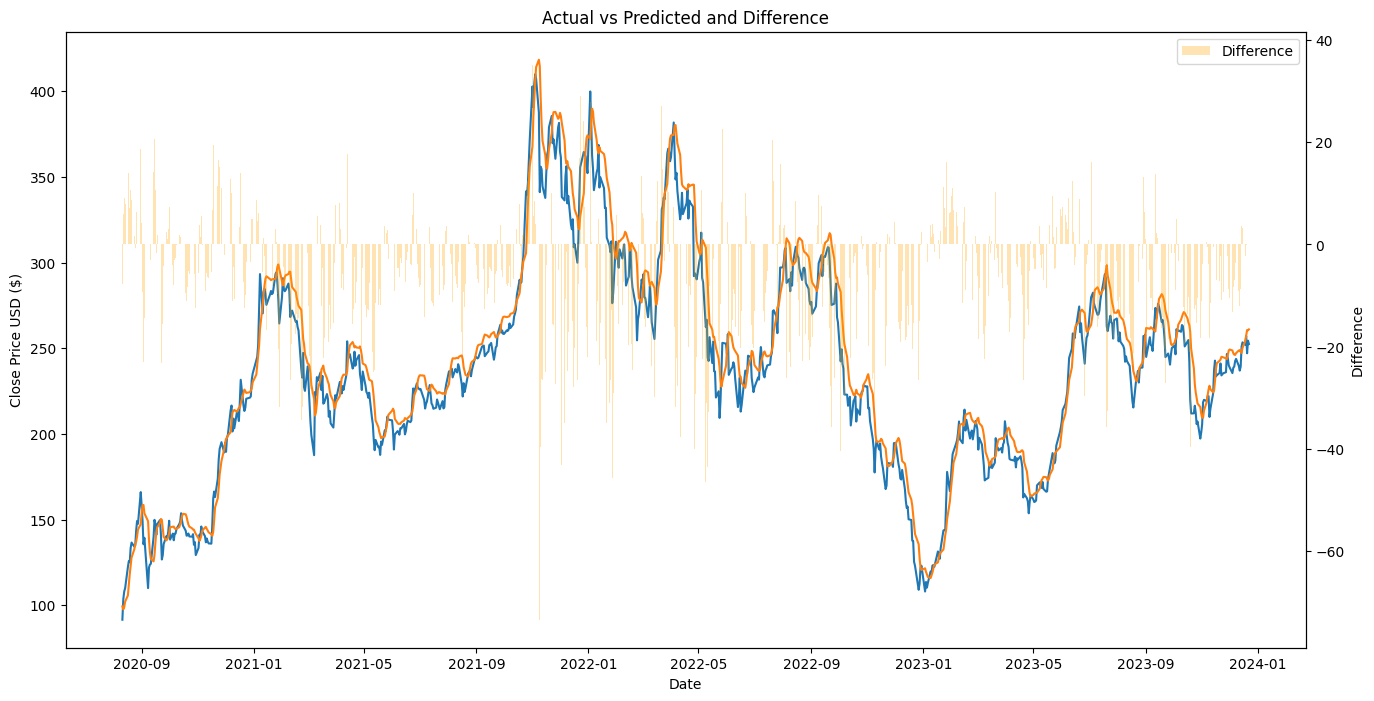

In [143]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax1 = plt.subplots(figsize=(16, 8))

# Line plot for Close and Predictions
ax1.plot(valid[['Close', 'Predictions']])
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price USD ($)')
ax1.legend(['Close', 'Predictions'], loc='upper left')

# Bar plot for Difference
ax2 = ax1.twinx()
ax2.bar(valid.index, valid['Difference'], alpha=0.3, color='orange', label='Difference')
ax2.set_ylabel('Difference')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Actual vs Predicted and Difference')
plt.show()


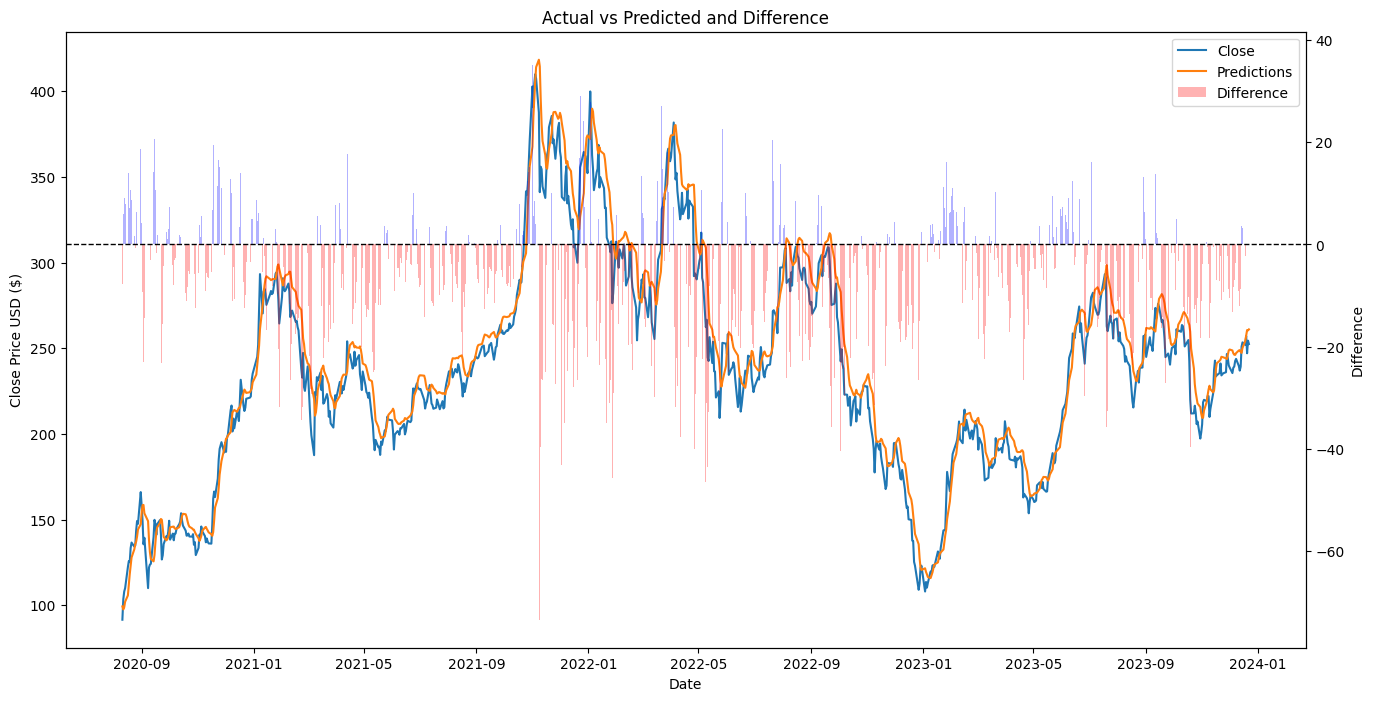

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax1 = plt.subplots(figsize=(16, 8))

# Line plot for Close and Predictions
ax1.plot(valid['Close'], label='Close')
ax1.plot(valid['Predictions'], label='Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price USD ($)')
ax1.legend(loc='upper left')

# Bar plot for Difference
ax2 = ax1.twinx()
ax2.bar(valid.index, valid['Difference'], color=['red' if x < 0 else 'blue' for x in valid['Difference']], alpha=0.3, label='Difference')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_ylabel('Difference')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Actual vs Predicted and Difference')
plt.show()


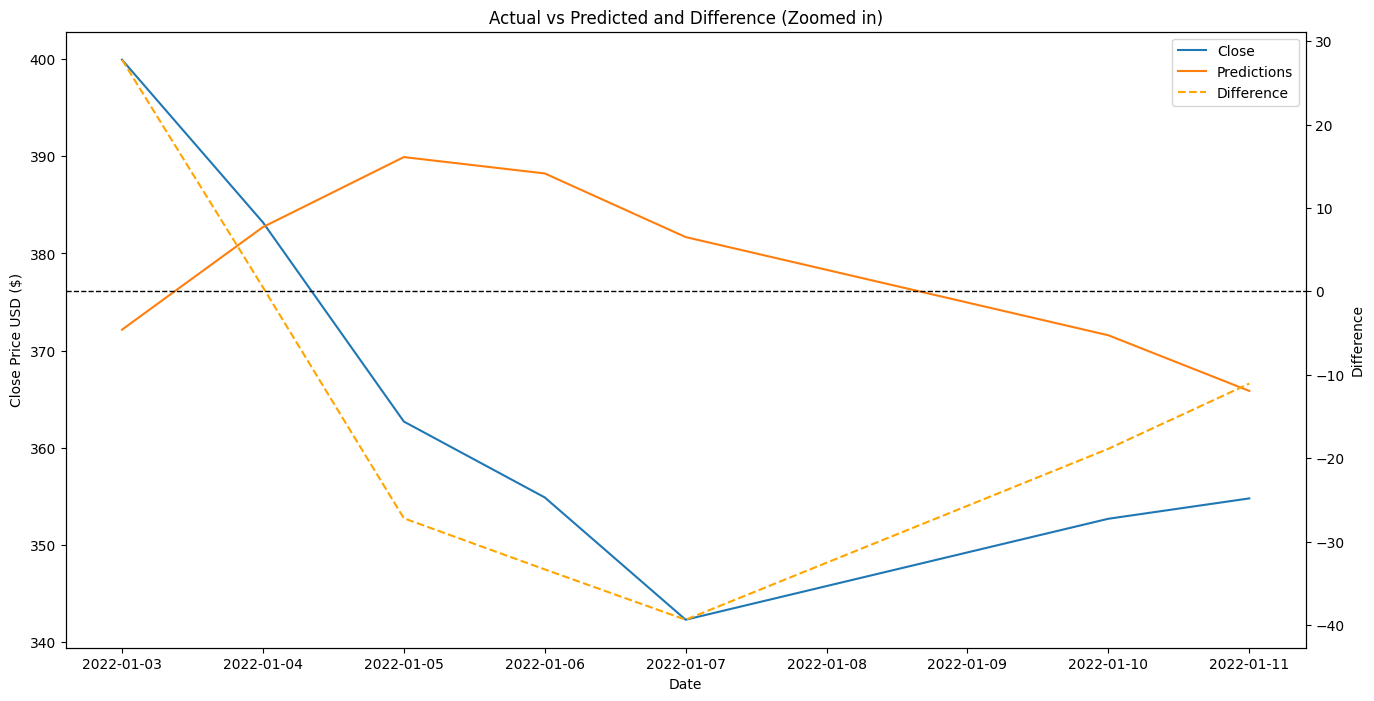

In [145]:
import datetime as dt
# Filter the data to only include the first 30 days starting from January 2022
start_date = dt.datetime(2022, 1, 1)
end_date = start_date + dt.timedelta(days=10)
valid_zoomed = valid[(valid.index >= start_date) & (valid.index <= end_date)]

fig, ax1 = plt.subplots(figsize=(16, 8))

# Line plot for Close and Predictions
ax1.plot(valid_zoomed['Close'], label='Close')
ax1.plot(valid_zoomed['Predictions'], label='Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price USD ($)')
ax1.legend(loc='upper left')

# Line plot for Difference
ax2 = ax1.twinx()
ax2.plot(valid_zoomed['Difference'], linestyle='--', color='orange', label='Difference')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_ylabel('Difference')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Actual vs Predicted and Difference (Zoomed in)')
plt.show()

<ipython-input-146-db63aa5c244c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference'] = valid['Close'] - valid['Predictions']


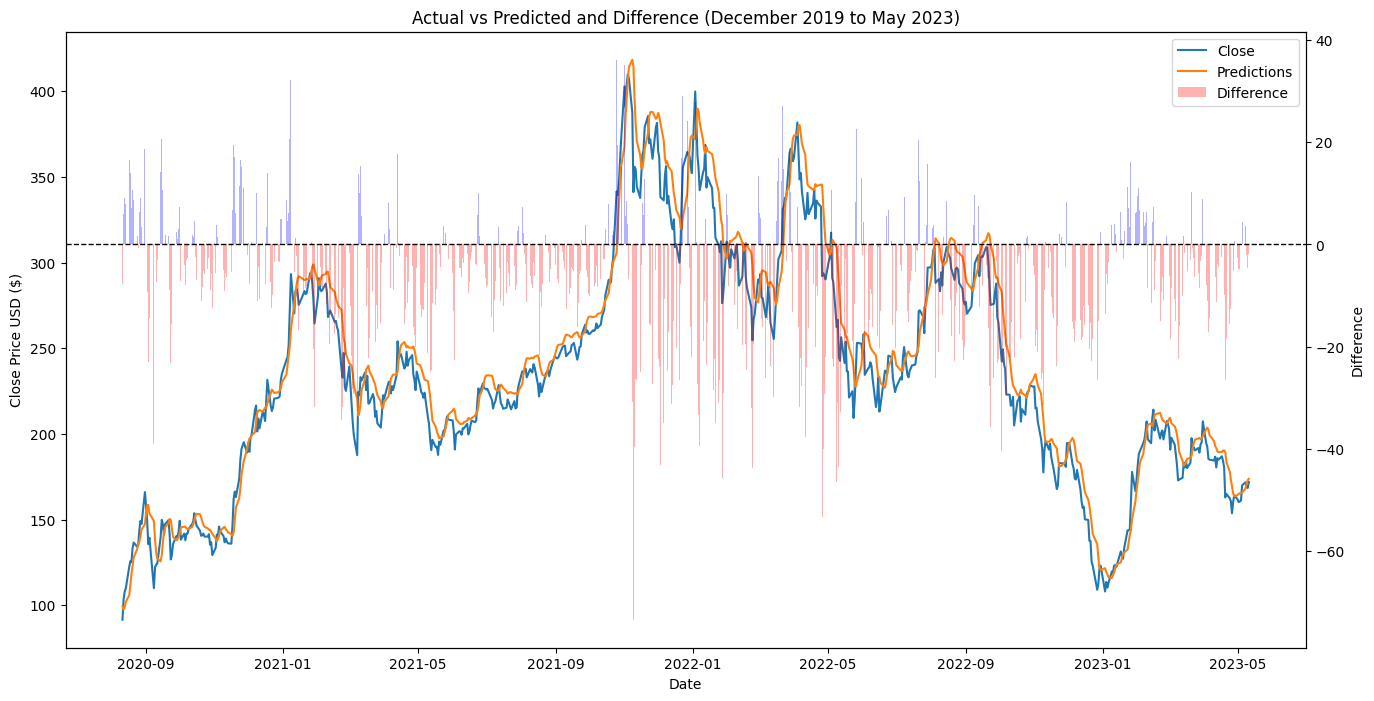

In [146]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# Assuming 'valid' contains the relevant data
valid['Difference'] = valid['Close'] - valid['Predictions']

# Filter the data to include from December 2019 to May 11, 2023
start_date = dt.datetime(2019, 12, 1)
end_date = dt.datetime(2023, 5, 11)
valid_zoomed = valid[(valid.index >= start_date) & (valid.index <= end_date)]

fig, ax1 = plt.subplots(figsize=(16, 8))

# Line plot for Close and Predictions
ax1.plot(valid_zoomed['Close'], label='Close')
ax1.plot(valid_zoomed['Predictions'], label='Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price USD ($)')
ax1.legend(loc='upper left')

# Bar plot for Difference
ax2 = ax1.twinx()
ax2.bar(valid_zoomed.index, valid_zoomed['Difference'],
        color=['red' if x < 0 else 'blue' for x in valid_zoomed['Difference']],
        alpha=0.3, label='Difference')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_ylabel('Difference')


# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Actual vs Predicted and Difference (December 2019 to May 2023)')
plt.show()


<ipython-input-147-e831b533774e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference'] = valid['Close'] - valid['Predictions']


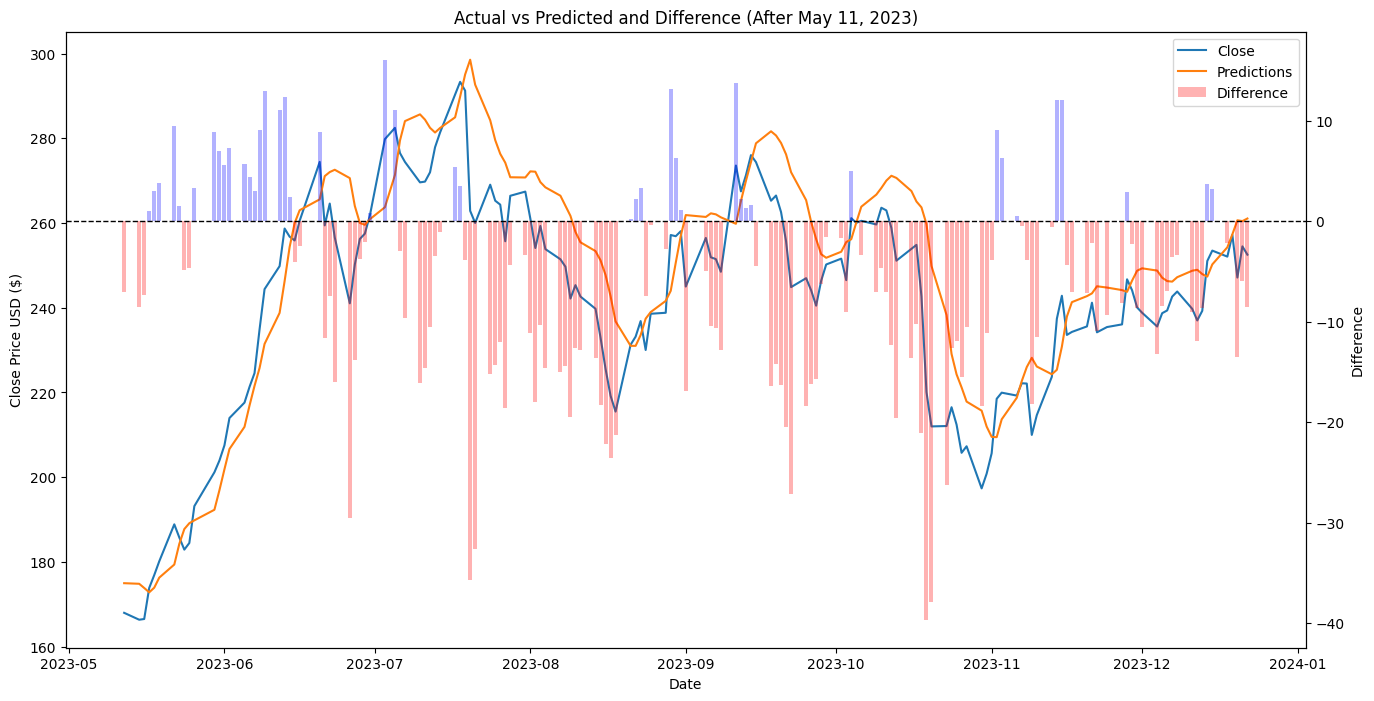

In [147]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

# Assuming 'valid' contains the relevant data
valid['Difference'] = valid['Close'] - valid['Predictions']

# Filter the data to include dates after May 11, 2023
start_date = dt.datetime(2023, 5, 12)
valid_zoomed = valid[valid.index >= start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))

# Line plot for Close and Predictions
ax1.plot(valid_zoomed['Close'], label='Close')
ax1.plot(valid_zoomed['Predictions'], label='Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price USD ($)')
ax1.legend(loc='upper left')

# Bar plot for Difference
ax2 = ax1.twinx()
ax2.bar(valid_zoomed.index, valid_zoomed['Difference'],
        color=['red' if x < 0 else 'blue' for x in valid_zoomed['Difference']],
        alpha=0.3, label='Difference')
ax2.axhline(0, color='black', linewidth=1, linestyle='--')
ax2.set_ylabel('Difference')

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Actual vs Predicted and Difference (After May 11, 2023)')
plt.show()
